# DCF Part 3: Final Model

Here we bring it all together. The end goal here is to get a DCF model-implied share price.

Plan:

1. Start with LTM data to get the most recent starting point
2. Use assumptions about projections. These will be hardcoded up front, including projected revenue growth, margins, and reinvestment rate. All must be for the same number of years in the future.
3. Create projections dataframe such that Year 1 is 12 months from the LTM data we just retrieved.
4. Use projected ratios to generate $-value projections from Revenue to NOPAT to FCF.
5. Discount FCF to the present
6. Compute Terminal Value using Gordon Growth Model, Discount to PV
7. Compute model-implied firm value and compute share price

This is our in-class project that we will work on progressively through the mod.

Expectations:
1. Notebook is clean and neat, with no repeated code. It has clearly labeled sections for inputs/imports at the beginning. Code is sufficiently commented to demonstrate your understanding of the code and help you or anyone else who may use this code later. All numbers should be formatted so they are readable (so, use commas with large numbers, only a few decimal points).
2. All calculations are correct and all discussion questions are answered completely but concisely, demonstrating a depth of understanding.

Workflow:
1. Notebooks are inherently experimental and allow you to try things, however that requires some good habits
2. Once you are "done" in any sense, you always need to "clean up" your notebook to make it presentable. You'd do the same in Excel - you've tried lots of things, etc. but before you present it, you clean it up.
3. Finally, restart the Runtime/Kernel and run it cleanly all the way top to bottom one time.

Then, its ready to go.


# Always put Imports and Installs at the beginning

And only put them in once.

Set display options here if you are using them.

Set API Keys here if you need them.

In [96]:
# necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


import yfinance as yf

In [97]:
# Set Ticker we are modeling
ticker_symbol = 'MSFT'
company_name = "Microsoft"

eff_tax_rate = 0.19 # need to set Effective Tax Rate, validate
marg_tax_rate = 0.25 # for WACC, given

# Scale Factor: this is what we divide numbers by, 1000000 is $M
scale_factor = 1000000
scale_name = 'M'

In [98]:
# Format setting for the model - tame the decimals!
pd.reset_option('display.float_format')
pd.set_option('display.float_format', lambda x: '{:,.2f}'.format(x))

## 1 Assumptions about Projection Patterns

This is a "minmimalist" model which means we only need the following:
1. Revenue Growth: To project Revenue
2. EBIT Margin: Go from Revenue to EBIT
3. Effective Tax Rate: Go from EBIT to NOPAT
4. Reinvestment Rate: Go from NOPAT to FCF



In [99]:
ss_growth = 0.03
growth_pattern = [.20, .15, .15, .15, .10, 0.10, 0.10, 0.08, 0.08, 0.06] #must be list the same length as time_horizon

reinv_rate_pattern = [0.4, 0.4, 0.3, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
assert len(growth_pattern) == len(reinv_rate_pattern), "Time patterns do not match - Reinv Rate."

ebit_margin = [0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46, 0.46]
assert len(growth_pattern) == len(ebit_margin), "Time patterns do not match - EBIT."

time_horizon = len(growth_pattern)
print(f"Length of projection period: {len(growth_pattern)} years")

Length of projection period: 10 years


In [100]:
# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Get shares outstanding data
shares_outstanding = ticker.info['sharesOutstanding']

print(f"Shares Outstanding for {ticker_symbol}: {shares_outstanding:,.2f} {scale_name}")

Shares Outstanding for MSFT: 7,432,377,655.00 M


## 2 Need LTM Data for starting point

Yahoo! Finance does not have LTM data - you need to create it yourself. Really all we need is LTM Revenue.

In [101]:
# get LTM data from yfinance
ltm_data = ticker.quarterly_financials.T.sort_index()

# use .iloc to get most recent 4 quarters of data only
ltm_data = ltm_data.iloc[-4:]

# print it out
ltm_data

,Tax Effect Of Unusual Items,Tax Rate For Calcs,Normalized EBITDA,Total Unusual Items,Total Unusual Items Excluding Goodwill,Net Income From Continuing Operation Net Minority Interest,Reconciled Depreciation,Reconciled Cost Of Revenue,EBITDA,EBIT,...,Operating Expense,Research And Development,Selling General And Administration,Selling And Marketing Expense,General And Administrative Expense,Other Gand A,Gross Profit,Cost Of Revenue,Total Revenue,Operating Revenue
2024-12-31,"-203,220,000.00",0.18,"37,915,000,000.00","-1,129,000,000.00","-1,129,000,000.00","24,108,000,000.00","6,827,000,000.00","21,799,000,000.00","36,786,000,000.00","29,959,000,000.00",...,"16,180,000,000.00","7,917,000,000.00","8,263,000,000.00","6,440,000,000.00","1,823,000,000.00","1,823,000,000.00","47,833,000,000.00","21,799,000,000.00","69,632,000,000.00","69,632,000,000.00"
2025-03-31,"69,660,000.00",0.18,"40,324,000,000.00","387,000,000.00","387,000,000.00","25,824,000,000.00","8,740,000,000.00","21,919,000,000.00","40,711,000,000.00","31,971,000,000.00",...,"16,147,000,000.00","8,198,000,000.00","7,949,000,000.00","6,212,000,000.00","1,737,000,000.00","1,737,000,000.00","48,147,000,000.00","21,919,000,000.00","70,066,000,000.00","70,066,000,000.00"
2025-06-30,"495,125.09",0.17,"44,431,000,000.00","3,000,000.00","3,000,000.00","27,233,000,000.00","11,203,000,000.00","24,014,000,000.00","44,434,000,000.00","33,231,000,000.00",...,"18,104,000,000.00","8,829,000,000.00","9,275,000,000.00","7,285,000,000.00","1,990,000,000.00","1,990,000,000.00","52,427,000,000.00","24,014,000,000.00","76,441,000,000.00","76,441,000,000.00"
2025-09-30,"187,150,000.00",0.19,"47,075,000,000.00","985,000,000.00","985,000,000.00","27,747,000,000.00","13,061,000,000.00","24,043,000,000.00","48,060,000,000.00","34,999,000,000.00",...,"15,669,000,000.00","8,146,000,000.00","7,523,000,000.00","5,717,000,000.00","1,806,000,000.00","1,806,000,000.00","53,630,000,000.00","24,043,000,000.00","77,673,000,000.00","77,673,000,000.00"


In [102]:
# If you don't have it already, create this variable `ltm_revenue` that is a float (not dataframe), with only revenue, scaled.
ltm_revenue = ltm_data['Total Revenue'].sum()

print(f"Most Recent Revenue for {ticker_symbol}'s Quarterly Data(${scale_name}): {ltm_revenue/scale_factor:,.2f}")

# here is the most recent date from which we begin our projections - this should be a datetime data type (not a string or float or int, etc.)
most_recent_date = ltm_data.index[-1]

print(f"Most Recent Date for {ticker_symbol}'s Quarterly Data: {most_recent_date}")

Most Recent Revenue for MSFT's Quarterly Data($M): 293,812.00
Most Recent Date for MSFT's Quarterly Data: 2025-09-30 00:00:00


## 3 Create dataframe for projections

This is just gathering our assumptions and using the right dates for them

In [103]:
# GIVEN: Just run this code. This is a bit more advanced than I expect most of you can do
#        Feel free to paste it into ChatGPT for a more in-depth explanation.
# this cell gets the dates for our projections going forward

# first, a lookup dictionary that allows us to convert a numeric month to a specific code for datetime objects
# the "A" stands for annual, so these codes will generate Annual intervals starting in that month, which is our goal.
freq_dict = {1:'A-JAN',2:'A-FEB',3:'A-MAR',4:'A-APR', 5:'A-MAY',6:'A-JUN',
             7:'A-JUL',8:'A-AUG', 9:'A-SEP',10:'A-OCT',11:'A-NOV',12:'A-DEC'}

# most_recent_date.month is an integer 1-12 representing the month part of the date.
# So, can you tell what this does?
f = freq_dict[most_recent_date.month]
#print result
print(f"This should match month above for most recent month in the above code cell: {f}\n")

# Generate the new dates for the DataFrame, matching the "growth_pattern" list above
new_dates = pd.date_range(start=most_recent_date, periods=len(growth_pattern)+1, freq=f)

print(f"Dates going forward, starting with time 0:")
print(new_dates)
print("\n")



This should match month above for most recent month in the above code cell: A-SEP

Dates going forward, starting with time 0:
DatetimeIndex(['2025-09-30', '2026-09-30', '2027-09-30', '2028-09-30',
               '2029-09-30', '2030-09-30', '2031-09-30', '2032-09-30',
               '2033-09-30', '2034-09-30', '2035-09-30'],
              dtype='datetime64[ns]', freq='YE-SEP')




/tmp/ipython-input-1352665904.py:17: FutureWarning: 'A-SEP' is deprecated and will be removed in a future version, please use 'YE-SEP' instead.
  new_dates = pd.date_range(start=most_recent_date, periods=len(growth_pattern)+1, freq=f)


In [104]:
# Create the projections DataFrame using the new_dates as index
# and the provided lists of projections given above as columns
# BE CAREFUL of dates. The above cell generates a sequence of dates starting today (T=0)
#                      The list objects with projections by definition start at T=1.

projections = pd.DataFrame(index=new_dates[1:])

projections['Revenue Growth'] = growth_pattern
projections['EBIT Margin'] = ebit_margin
projections['Reinvestment Rate'] = reinv_rate_pattern

# print
projections

,Revenue Growth,EBIT Margin,Reinvestment Rate
2026-09-30,0.20,0.46,0.40
2027-09-30,0.15,0.46,0.40
2028-09-30,0.15,0.46,0.30
2029-09-30,0.15,0.46,0.20
2030-09-30,0.10,0.46,0.20
2031-09-30,0.10,0.46,0.20
2032-09-30,0.10,0.46,0.20
2033-09-30,0.08,0.46,0.20
2034-09-30,0.08,0.46,0.20
2035-09-30,0.06,0.46,0.20


## 4 Now create projections in $

In [105]:
# Given LTM revenue and the revenue growth pattern (the python list above)
# generate the $M projections for revenue
# (this may take a few lines of code, not just one or two)
projected_revenue = []
current_revenue = ltm_revenue

for i in range(time_horizon):
    current_revenue *= (1 + growth_pattern[i])
    projected_revenue.append(current_revenue)

projections['Revenue'] = projected_revenue

# 2. Now compute projected EBIT
# EBIT = Revenue * EBIT Margin
projections['EBIT'] = projections['Revenue'] * np.array(ebit_margin)

# 3. Calculate projected NOPAT (Net Operating Profit After Tax)
# NOPAT = EBIT * (1 - Effective Tax Rate)
projections['NOPAT'] = projections['EBIT'] * (1 - eff_tax_rate)

# 4. Calculate the projected FCF (Free Cash Flow)
# FCF = NOPAT * (1 - Reinvestment Rate)
projections['FCF'] = projections['NOPAT'] * (1 - np.array(reinv_rate_pattern))

# create a list of column names for only the ratios in the projections dataframe
ratios = ['Revenue Growth', 'EBIT Margin','Reinvestment Rate']
# repeat but for $ value columns
values = ['Revenue','EBIT','NOPAT','FCF']


# print them out
display(projections[ratios])
display(projections[values]/scale_factor)

,Revenue Growth,EBIT Margin,Reinvestment Rate
2026-09-30,0.20,0.46,0.40
2027-09-30,0.15,0.46,0.40
2028-09-30,0.15,0.46,0.30
2029-09-30,0.15,0.46,0.20
2030-09-30,0.10,0.46,0.20
2031-09-30,0.10,0.46,0.20
2032-09-30,0.10,0.46,0.20
2033-09-30,0.08,0.46,0.20
2034-09-30,0.08,0.46,0.20
2035-09-30,0.06,0.46,0.20


,Revenue,EBIT,NOPAT,FCF
2026-09-30,"352,574.40","162,184.22","131,369.22","78,821.53"
2027-09-30,"405,460.56","186,511.86","151,074.60","90,644.76"
2028-09-30,"466,279.64","214,488.64","173,735.80","121,615.06"
2029-09-30,"536,221.59","246,661.93","199,796.16","159,836.93"
2030-09-30,"589,843.75","271,328.12","219,775.78","175,820.62"
2031-09-30,"648,828.12","298,460.94","241,753.36","193,402.69"
2032-09-30,"713,710.94","328,307.03","265,928.70","212,742.96"
2033-09-30,"770,807.81","354,571.59","287,202.99","229,762.39"
2034-09-30,"832,472.44","382,937.32","310,179.23","248,143.38"
2035-09-30,"882,420.78","405,913.56","328,789.98","263,031.99"


## 5 Get WACC from our WACC notebook

We did this already, so just need to import it.

I put the following prompt in ChatGPT:
```
take this data:

	WACC
0	7.67
1	8.72
2	9.77

and make it so I can turn it into a pandas dataframe if I paste the code
```

In [106]:
import pandas as pd

# using our WACC notebook and some AI help, create a data frame for WACC.
# It should look like the dataframe shown above in the text block.
# It may take several lines of code.
wacc_data = {
    'WACC': [7.96, 9.25, 10.54]
}
wacc_df = pd.DataFrame(wacc_data)

# print
print(wacc_df)

# Also, for a first pass, we need a single wacc, so set this float value:
wacc = wacc_df['WACC'].iloc[1] / 100 # Taking the middle value and converting to decimal

print(f"WACC: {wacc:,.4f}")

   WACC
0  7.96
1  9.25
2 10.54
WACC: 0.0925


## 6 Discount FCF to Present

In [107]:
# Calculate the present value of future cash flows
projections = projections.reset_index(drop=True)
projections['Year'] = projections.index + 1

# Add the present values to the projections DataFrame
projections['PV of FCF'] = projections['FCF'] / (1 + wacc)**projections['Year']

# print
projections[['FCF','PV of FCF']]/scale_factor

,FCF,PV of FCF
0,"78,821.53","72,147.86"
1,"90,644.76","75,945.11"
2,"121,615.06","93,265.93"
3,"159,836.93","112,199.61"
4,"175,820.62","112,969.86"
5,"193,402.69","113,745.40"
6,"212,742.96","114,526.26"
7,"229,762.39","113,215.89"
8,"248,143.38","111,920.51"
9,"263,031.99","108,591.07"


## 7 PV of Terminal Value

In [108]:
# Calculate the terminal value using the Gordon Growth Model (also known as the Perpetuity Growth Model)
terminal_value = projections['FCF'].iloc[-1] * (1 + ss_growth)/ (wacc - ss_growth)

print(f"TV for {ticker_symbol}: (${scale_name}) {terminal_value/scale_factor:,.2f}")

# discount it to the present
present_value_of_terminal = terminal_value / (1 + wacc)**time_horizon

print(f"PV of TV for {ticker_symbol}: (${scale_name}) {present_value_of_terminal/scale_factor:,.2f}")

TV for MSFT: ($M) 4,334,767.15
PV of TV for MSFT: ($M) 1,789,580.82


## 8 Firm Value and Share Price

In [109]:
# compute PV of firm value
firm_value = projections['PV of FCF'].sum() + present_value_of_terminal

print(f"Firm Value for {ticker_symbol}: (${scale_name}) {firm_value/scale_factor:,.2f}")

# compute share price
# get total debt from the ticker object
total_debt = ticker.info['totalDebt']

#get total cash from the ticker object
total_cash = ticker.info['totalCash']

# compute share price
share_price = (firm_value - total_debt + total_cash) / shares_outstanding

print(f"Share Price for {ticker_symbol}: ${share_price:,.2f}")

Firm Value for MSFT: ($M) 2,818,108.31
Share Price for MSFT: $376.70


## 9 Visualizing Uncertainty

Let's take our upper and lower WACC to quantify the uncertainty in our share price estimate.

What you are doing here is creating a loop from what we just did:
1. Create a for loop that iterates through the three estimates of WACC
2. For each wacc, compute the PV of intermediate CFC, TV, PV of TV and share price
3. The output should be a list of share prices, upper, middle (what we just computed) and lower.

Its good to repeate the middle wacc calculation to validate it is the same as above.

In [110]:
# write code here. This is likely a large block of code, maybe 20 lines or more
share_prices = []

for index, row in wacc_df.iterrows():
    current_wacc = row['WACC'] / 100

    # Recalculate PV of FCF
    pv_of_fcf_for_wacc = (projections['FCF'] / (1 + current_wacc)**projections['Year']).sum()

    # Recalculate Terminal Value
    terminal_value_for_wacc = projections['FCF'].iloc[-1] * (1 + ss_growth) / (current_wacc - ss_growth)

    # Recalculate Present Value of Terminal Value
    present_value_of_terminal_for_wacc = terminal_value_for_wacc / (1 + current_wacc)**time_horizon

    # Recalculate Firm Value
    firm_value_for_wacc = pv_of_fcf_for_wacc + present_value_of_terminal_for_wacc

    # Recalculate Share Price
    share_price_for_wacc = (firm_value_for_wacc - total_debt + total_cash) / shares_outstanding
    share_prices.append(share_price_for_wacc)

upper_share_price = share_prices[0]
middle_share_price = share_prices[1]
lower_share_price = share_prices[2]

# output is three stock prices: upper, middle and lower
# print

print(f"Share Price Estimates for {company_name} ({ticker_symbol}):")
print(f"Upper Estimate (based on lowest WACC): ${upper_share_price:,.2f}")
print(f"Middle Estimate (based on middle WACC): ${middle_share_price:,.2f}")
print(f"Lower Estimate (based on highest WACC): ${lower_share_price:,.2f}")

# Validate the middle estimate against the previously computed share_price
print(f"\nValidation: Previous single WACC share price: ${share_price:,.2f}")
print(f"Validation: Middle estimate from loop: ${middle_share_price:,.2f}")

Share Price Estimates for Microsoft (MSFT):
Upper Estimate (based on lowest WACC): $487.59
Middle Estimate (based on middle WACC): $376.70
Lower Estimate (based on highest WACC): $304.30

Validation: Previous single WACC share price: $376.70
Validation: Middle estimate from loop: $376.70


Now create a plot!

1. Get 1 year historical stock prices data for the `ticker`
2. Plot it
3. Also plot, as horizontal lines, the upper, middle, and lower stock price estimates
4. Shade the area between the upper and lower stock price

Be sure to use accurate and informative axis labels, plot titles, etc. with correct units.


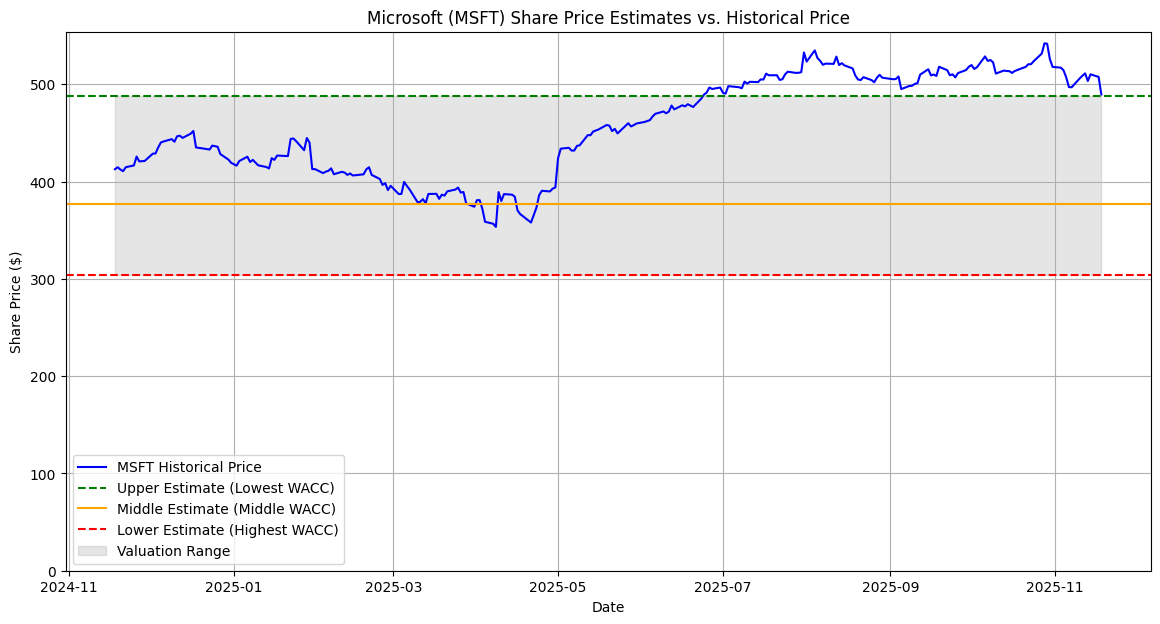

In [111]:
# Download daily stock prices for the last year
hist_data = ticker.history(period="1y")

plt.figure(figsize=(14, 7))
# Plot the daily stock prices
plt.plot(hist_data.index, hist_data['Close'], label=f'{ticker_symbol} Historical Price', color='blue')

# Plot the horizontal lines for the main estimate and the confidence intervals
plt.axhline(y=upper_share_price, color='green', linestyle='--', label='Upper Estimate (Lowest WACC)')
plt.axhline(y=middle_share_price, color='orange', linestyle='-', label='Middle Estimate (Middle WACC)')
plt.axhline(y=lower_share_price, color='red', linestyle='--', label='Lower Estimate (Highest WACC)')

# Fill between the Upper CI and Lower CI for transparency
plt.fill_between(hist_data.index, lower_share_price, upper_share_price, color='gray', alpha=0.2, label='Valuation Range')

# Add title and labels
plt.title(f'{company_name} ({ticker_symbol}) Share Price Estimates vs. Historical Price')
plt.xlabel('Date')
plt.ylabel('Share Price ($)')
plt.legend()
plt.grid(True)
plt.ylim(ymin=0)

# Show the plot
plt.show()